##### <span style="color: #FF0000;">Overview of the Process</span>

The goal was to enhance the data provided in class, labeled as the "houseprice" dataset, with the "Housing Prices Dataset" identified as a continuation or separate version of the original. This new dataset, sourced from https://www.kaggle.com/datasets/yasserh/housing-prices-dataset, contains more unique features. The process involved cleaning, transforming, and merging these datasets, followed by a quality control analysis to ensure data integrity and consistency. The following notes detail each stage of this enhancement workflow.

##### <span style="color: #1E90FF;">Files Used in the Process</span>

1. **Input Files**:
   - `Housing Prices Dataset.csv`: Original dataset containing housing price information.
   - `houseprice.csv`: Second dataset with potentially different or additional housing data.

2. **Intermediate File**:
   - `cleaned_merged_housing_dataset.csv`: Result of initial cleaning and merging, used for verification.

3. **Output Files**:
   - `merged_housing_dataset.csv`: Cleaned and merged dataset.
   - `further_cleaned_standardized_housing_dataset.csv`: Final dataset after additional cleaning and standardization.

4. **Documentation**:
   - `Data preparation.md`: This file, documenting the entire data preparation process.


In [1]:
%pip install pandas numpy matplotlib seaborn scikit-learn


Note: you may need to restart the kernel to use updated packages.Defaulting to user installation because normal site-packages is not writeable




[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
houseprice_df = pd.read_csv(r"G:\Uni\2nd year\Intro to AI\Clustering\assignment-1-ryantigi254\Clustering\Weekly Tasks\data\Housing Prices Dataset.csv")
housing_prices_df = pd.read_csv(r"G:\Uni\2nd year\Intro to AI\Clustering\assignment-1-ryantigi254\Clustering\Weekly Tasks\data\houseprice .CSV")
cleaned_data_df = pd.read_csv(r"G:\Uni\2nd year\Intro to AI\Clustering\assignment-1-ryantigi254\Clustering\Weekly Tasks\data\cleaned_merged_housing_dataset.csv")

# 1. Analysis and Merging Script

def clean_and_prepare_data(df, column_mappings):
    # Rename columns based on the provided mappings
    df = df.rename(columns=column_mappings)
    
    # Clean and convert area column
    if 'area' in df.columns:
        df['area'] = df['area'].astype(str).str.replace(',', '').str.extract('(\d+)').astype(float)
    
    # Clean and convert other numeric columns
    for col in ['bedrooms', 'bathrooms']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    return df

def analyze_and_merge(houseprice_df, housing_prices_df):
    # Clean and prepare both datasets
    houseprice_df = clean_and_prepare_data(houseprice_df, {})
    housing_prices_df = clean_and_prepare_data(housing_prices_df, {
        'Sqr Ft': 'area',
        'Beds': 'bedrooms',
        'Bath': 'bathrooms'
    })
    
    # Attempt to merge using available addresses (if applicable)
    if 'Address' in houseprice_df.columns and 'Address' in housing_prices_df.columns:
        merged_data = pd.merge(houseprice_df, housing_prices_df, on='Address', how='outer', suffixes=('_houseprice', '_housing_prices'))
    else:
        # Merge based on similar property features
        area_tolerance = 100  # square feet
        bedroom_tolerance = 1
        bathroom_tolerance = 1

        # Create a helper function to match properties
        def match_properties(house_row, housing_df):
            matches = housing_df[
                (abs(housing_df['area'] - house_row['area']) <= area_tolerance) &
                (abs(housing_df['bedrooms'] - house_row['bedrooms']) <= bedroom_tolerance) &
                (abs(housing_df['bathrooms'] - house_row['bathrooms']) <= bathroom_tolerance)
            ]
            return matches

        # Lists to store matched properties
        matched_properties = []
        unmatched_properties = []

        # Iterate through properties in houseprice_df
        for _, house in houseprice_df.iterrows():
            matches = match_properties(house, housing_prices_df)
            if not matches.empty:
                for _, match in matches.iterrows():
                    matched_properties.append(house.combine_first(match))
            else:
                unmatched_properties.append(house)

        # Create DataFrames from matched and unmatched properties
        merged_data = pd.DataFrame(matched_properties)
        unmatched_data = pd.DataFrame(unmatched_properties)

        print("Number of Unmatched Properties:", unmatched_data.shape[0])

    # Save the merged dataset
    merged_data.to_csv(r"G:\Uni\2nd year\Intro to AI\Clustering\assignment-1-ryantigi254\Clustering\Weekly Tasks\data\merged_housing_dataset.csv", index=False)
    print("Merged dataset saved successfully.")

    # Plotting the distribution of area differences for quality control
    if not merged_data.empty:
        if 'area_houseprice' in merged_data.columns and 'area_housing_prices' in merged_data.columns:
            area_diff = merged_data['area_houseprice'] - merged_data['area_housing_prices']
            plt.figure(figsize=(10, 6))
            plt.hist(area_diff, bins=30)
            plt.title('Distribution of Area Differences')
            plt.xlabel('Area Difference (sq ft)')
            plt.ylabel('Frequency')
            plt.show()

    return merged_data

merged_data_df = analyze_and_merge(houseprice_df, housing_prices_df)



Number of Unmatched Properties: 128
Merged dataset saved successfully.


C:\Users\22837352\AppData\Local\Temp\ipykernel_30440\1616841782.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].fillna(df[col].mean())
C:\Users\22837352\AppData\Local\Temp\ipykernel_30440\1616841782.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Price'] = df['Price'].astype(str).str.replace(r'[$,+]', '', regex=True).str.extract('(\d+\.\d*|\d+)')[0].astype(float)
C:\Users\22837352\AppData\Local\Temp\ipykernel_30440\1616841782.py:32: SettingWithCopyWarning: 
A value is trying 

Cleaned dataset saved successfully.


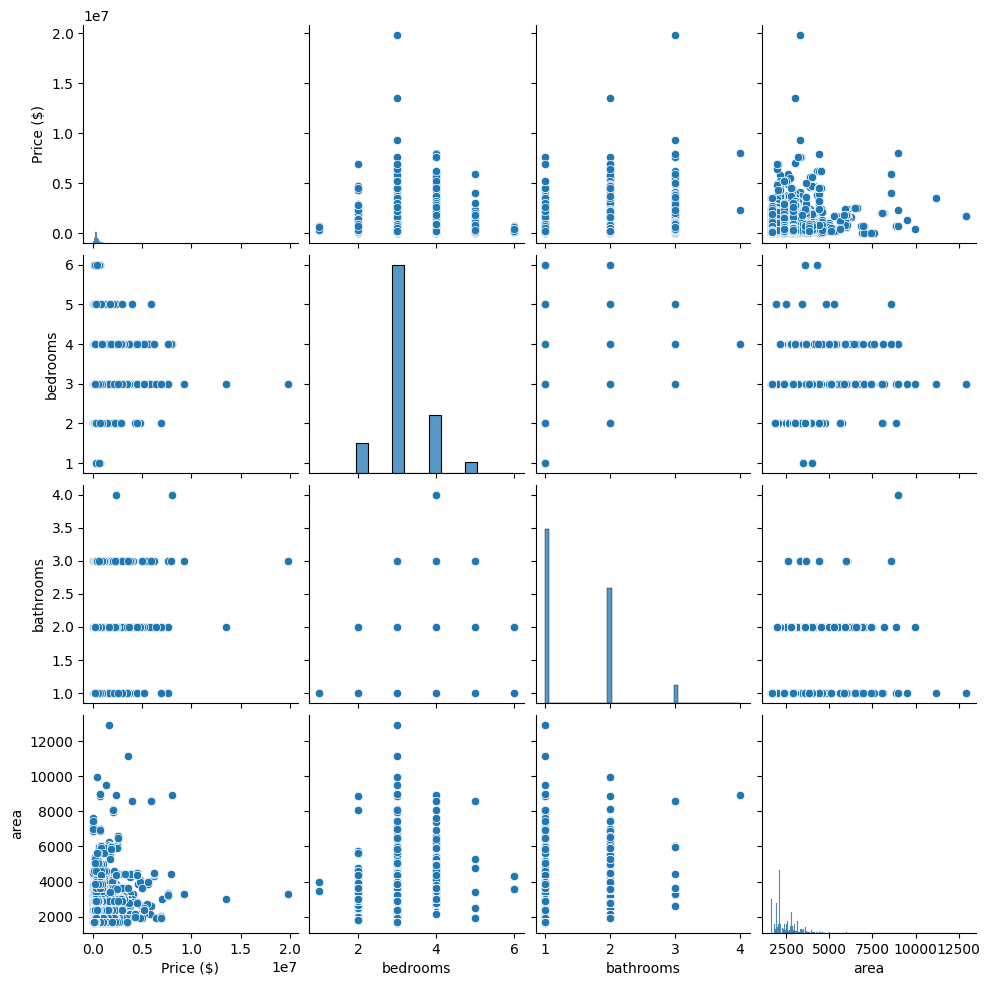

In [5]:
# 2. Cleaning Script
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def clean_dataset(df):
    # Dropping duplicates
    df = df.drop_duplicates()

    # Handling missing values by filling with mean for numerical features
    numerical_cols = ["Price", "area", "bedrooms", "bathrooms"]
    for col in numerical_cols:
        if col in df.columns and pd.api.types.is_numeric_dtype(df[col]):
            df[col] = df[col].fillna(df[col].mean())

    # Fixing formatting issues such as dollar signs and removing non-numeric characters
    if 'Price' in df.columns:
        df['Price'] = df['Price'].astype(str).str.replace(r'[$,+]', '', regex=True).str.extract('(\d+\.\d*|\d+)')[0].astype(float)
    
    # Removing units from 'Price per Square Foot ($/sqft)' column values and renaming column
    if 'Price per Square Foot ($/sqft)' in df.columns:
        df['Price per Square Foot ($/sqft)'] = df['Price per Square Foot ($/sqft)'].astype(str).str.replace(r'[$/sqft]', '', regex=True).str.extract('(\d+\.\d*|\d+)')[0].astype(float)
        df.rename(columns={'Price per Square Foot ($/sqft)': 'Price per Square Foot ($)'}, inplace=True)
    
    # Removing units from 'Lot Size (sqft/acres)' column values and renaming column
    if 'Lot Size (sqft/acres)' in df.columns:
        df['Lot Size (sqft/acres)'] = df['Lot Size (sqft/acres)'].astype(str).str.replace(r'[a-zA-Z, ]', '', regex=True).str.extract('(\d+\.\d*|\d+)')[0].astype(float)
        df.rename(columns={'Lot Size (sqft/acres)': 'Lot Size (sqft)'}, inplace=True)

    # Encoding categorical features where necessary
    if 'furnishingstatus' in df.columns:
        df['furnishingstatus'] = df['furnishingstatus'].map({'furnished': 2, 'semi-furnished': 1, 'unfurnished': 0})

    # Dropping redundant column
    if 'Address Full' in df.columns:
        df = df.drop(columns=['Address Full'])

    # Renaming columns to include units where applicable
    df.rename(columns={
        'Last Sold For': 'Last Sold For ($)',
        'Price': 'Price ($)',
        'Latitude': 'Latitude (degrees)',
        'Longitude': 'Longitude (degrees)'
    }, inplace=True)

    # Ensure there are no duplicate column names
    df = df.loc[:, ~df.columns.duplicated()]

    # Reset index to avoid duplicate index labels causing reindex errors
    df.reset_index(drop=True, inplace=True)

    # Save cleaned data
    df.to_csv(r"G:\Uni\2nd year\Intro to AI\Clustering\assignment-1-ryantigi254\Clustering\Weekly Tasks\data\cleaned_merged_housing_dataset.csv", index=False)
    print("Cleaned dataset saved successfully.")
    return df

# Example usage
cleaned_merged_data_df = clean_dataset(merged_data_df)

# Quality Control using Visualizations
try:
    actual_columns = [col for col in ['Price ($)', 'bedrooms', 'bathrooms', 'area'] if col in cleaned_merged_data_df.columns]
    if len(actual_columns) >= 2:  # need at least 2 columns for a pairplot
        sns.pairplot(cleaned_merged_data_df, vars=actual_columns)
        plt.show()
    else:
        print("Not enough columns for pairplot visualization")
except ValueError as e:
    print(f"Error during visualization: {e}")


In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def further_clean_and_standardize_dataset(df):
    # Dropping duplicates
    df = df.drop_duplicates()

    # Standardizing column names and adding units
    column_renames = {
        'Price': 'Price ($)',
        'area': 'Area (sqft)',
        'Latitude': 'Latitude (degrees)',
        'Longitude': 'Longitude (degrees)',
        'Last Sold For': 'Last Sold For ($)',
        'Price Sqr Ft': 'Price per Square Foot ($/sqft)',
        'Lot Size': 'Lot Size (sqft)',
    }
    df = df.rename(columns=column_renames)

    # Cleaning and converting numeric columns
    numeric_columns = ['Price ($)', 'Last Sold For ($)', 'Price per Square Foot ($/sqft)', 'Lot Size (sqft)', 'Area (sqft)']
    for col in numeric_columns:
        if col in df.columns:
            df[col] = df[col].astype(str).str.replace(r'[$,/sqft]', '', regex=True).str.extract('(\d+\.?\d*)')[0].astype(float)

    # Convert 'Lot Size' from acres to sqft if necessary
    if 'Lot Size (sqft)' in df.columns:
        df.loc[df['Lot Size (sqft)'] < 1000, 'Lot Size (sqft)'] *= 43560  # Convert acres to sqft

    # Ensure only one 'Address' column is retained
    address_columns = [col for col in df.columns if 'address' in col.lower()]
    if len(address_columns) > 1:
        df = df.rename(columns={address_columns[0]: 'Address'})
        for col in address_columns[1:]:
            df = df.drop(columns=[col])

    # Ensure there are no duplicate column names
    df = df.loc[:, ~df.columns.duplicated()]

    # Reset index to avoid duplicate index labels causing reindex errors
    df.reset_index(drop=True, inplace=True)

    return df

# Load the cleaned merged dataset
input_path = r"G:\Uni\2nd year\Intro to AI\Clustering\assignment-1-ryantigi254\Clustering\Weekly Tasks\data\cleaned_merged_housing_dataset.csv"
cleaned_merged_df = pd.read_csv(input_path)

# Further clean and standardize the dataset
further_cleaned_df = further_clean_and_standardize_dataset(cleaned_merged_df)

# Save the further cleaned and standardized dataset
output_path = r"G:\Uni\2nd year\Intro to AI\Clustering\assignment-1-ryantigi254\Clustering\Weekly Tasks\data\further_cleaned_standardized_housing_dataset.csv"
further_cleaned_df.to_csv(output_path, index=False)
print(f"Further cleaned and standardized dataset saved successfully to {output_path}")

# Display information about the further cleaned dataset
print("\nFurther Cleaned and Standardized Dataset Info:")
print(further_cleaned_df.info())

# Quality Control using Visualizations
try:
    actual_columns = [col for col in ['Price ($)', 'bedrooms', 'bathrooms', 'Area (sqft)'] if col in further_cleaned_df.columns]
    if len(actual_columns) >= 2:  # need at least 2 columns for a pairplot
        sns.pairplot(further_cleaned_df, vars=actual_columns)
        plt.savefig(r"G:\Uni\2nd year\Intro to AI\Clustering\assignment-1-ryantigi254\Clustering\Weekly Tasks\data\pairplot_visualization.png")
        plt.close()
        print("Pairplot visualization saved successfully.")
    else:
        print("Not enough columns for pairplot visualization")
except ValueError as e:
    print(f"Error during visualization: {e}")

Further cleaned and standardized dataset saved successfully to G:\Uni\2nd year\Intro to AI\Clustering\assignment-1-ryantigi254\Clustering\Weekly Tasks\data\further_cleaned_standardized_housing_dataset.csv

Further Cleaned and Standardized Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30683 entries, 0 to 30682
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Address                         30683 non-null  object 
 1   City                            30683 non-null  object 
 2   Last Sold For ($)               13956 non-null  float64
 3   Last Sold Year                  13956 non-null  float64
 4   Latitude (degrees)              30683 non-null  float64
 5   Longitude (degrees)             30683 non-null  float64
 6   Lot Size (sqft)                 27587 non-null  float64
 7   Price ($)                       30445 non-null  float64
 8   Price per Square Foot (

Misc


In [ ]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# def clean_and_prepare_data(df, column_mappings):
#     # Rename columns based on the provided mappings
#     df = df.rename(columns=column_mappings)
    
#     # Clean and convert area column
#     df['area'] = df['area'].astype(str).str.replace(',', '').str.extract('(\d+)').astype(float)
    
#     # Clean and convert other numeric columns
#     for col in ['bedrooms', 'bathrooms']:
#         df[col] = pd.to_numeric(df[col], errors='coerce')
    
#     return df

# def analyze_and_merge(houseprice_df, housing_prices_df):
#     # Clean and prepare both datasets
#     houseprice_df = clean_and_prepare_data(houseprice_df, {})
#     housing_prices_df = clean_and_prepare_data(housing_prices_df, {
#         'Sqr Ft': 'area',
#         'Beds': 'bedrooms',
#         'Bath': 'bathrooms'
#     })
    
#     # Setting tolerances to find matching properties
#     area_tolerance = 100  # square feet
#     bedroom_tolerance = 1
#     bathroom_tolerance = 1

#     # Lists to store matched properties
#     matched_properties = []

#     # Iterate through properties in houseprice_df
#     for _, house in houseprice_df.iterrows():
#         # Find matching properties in housing_prices_df
#         matches = housing_prices_df[
#             (abs(housing_prices_df['area'] - house['area']) <= area_tolerance) &
#             (abs(housing_prices_df['bedrooms'] - house['bedrooms']) <= bedroom_tolerance) &
#             (abs(housing_prices_df['bathrooms'] - house['bathrooms']) <= bathroom_tolerance)
#         ]
        
#         # If matches found, add to the list
#         for _, match in matches.iterrows():
#             matched_properties.append({
#                 'houseprice_area': house['area'],
#                 'houseprice_bedrooms': house['bedrooms'],
#                 'houseprice_bathrooms': house['bathrooms'],
#                 'housing_prices_area': match['area'],
#                 'housing_prices_bedrooms': match['bedrooms'],
#                 'housing_prices_bathrooms': match['bathrooms']
#             })

#     # Create a DataFrame from matched properties
#     merged_data = pd.DataFrame(matched_properties)

#     # Plotting the distribution of area differences
#     if not merged_data.empty:
#         area_diff = merged_data['houseprice_area'] - merged_data['housing_prices_area']
#         plt.figure(figsize=(10, 6))
#         plt.hist(area_diff, bins=30)
#         plt.title('Distribution of Area Differences')
#         plt.xlabel('Area Difference (sq ft)')
#         plt.ylabel('Frequency')
#         plt.savefig(r"G:\Uni\2nd year\Intro to AI\Clustering\assignment-1-ryantigi254\Clustering\Weekly Tasks\data\area_difference_distribution.png")
#         plt.close()

#     return merged_data

# # Load the datasets
# houseprice_df = pd.read_csv(r"G:\Uni\2nd year\Intro to AI\Clustering\assignment-1-ryantigi254\Clustering\Weekly Tasks\data\Housing Prices Dataset.csv")
# housing_prices_df = pd.read_csv(r"G:\Uni\2nd year\Intro to AI\Clustering\assignment-1-ryantigi254\Clustering\Weekly Tasks\data\houseprice .CSV")

# # Perform analysis and merging
# merged_data_df = analyze_and_merge(houseprice_df, housing_prices_df)

# # Display the first few rows of the merged data
# print(merged_data_df.head())

# # Display summary statistics of the merged data
# print(merged_data_df.describe())

# # Save the merged data to a CSV file
# merged_data_df.to_csv(r"G:\Uni\2nd year\Intro to AI\Clustering\assignment-1-ryantigi254\Clustering\Weekly Tasks\data\merged_housing_dataset.csv", index=False)
# print("Merged dataset saved successfully.")


# def clean_dataset(df):
#     # Dropping duplicates
#     df = df.drop_duplicates()

#     # Print column names for debugging
#     print("Columns in the DataFrame:", df.columns)

#     # Create a mapping of expected column names to actual column names
#     column_mapping = {
#         'Price': next((col for col in df.columns if col.lower() == 'price'), None),
#         'area': next((col for col in df.columns if col.lower() == 'area'), None),
#         'bedrooms': next((col for col in df.columns if col.lower() == 'bedrooms'), None),
#         'bathrooms': next((col for col in df.columns if col.lower() == 'bathrooms'), None)
#     }

#     # Filter out None values from the mapping
#     numerical_cols = [col for col in column_mapping.values() if col is not None]

#     # Handling missing values by filling with mean for numerical features
#     if numerical_cols:
#         df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

#     # Fixing formatting issues such as dollar signs and removing non-numeric characters
#     price_col = column_mapping['Price']
#     if price_col and price_col in df.columns:
#         df[price_col] = df[price_col].astype(str).str.replace("$", "").str.replace(",", "").astype(float)

#     # Encoding categorical features where necessary
#     if 'furnishingstatus' in df.columns:
#         df['furnishingstatus'] = df['furnishingstatus'].map({'furnished': 2, 'semi-furnished': 1, 'unfurnished': 0})

#     # Save cleaned data
#     df.to_csv(r"G:\Uni\2nd year\Intro to AI\Clustering\assignment-1-ryantigi254\Clustering\Weekly Tasks\data\cleaned_merged_housing_dataset.csv", index=False)
#     print("Cleaned dataset saved successfully.")
#     return df

# # Load the merged dataset
# merged_data_df = pd.read_csv(r"G:\Uni\2nd year\Intro to AI\Clustering\assignment-1-ryantigi254\Clustering\Weekly Tasks\data\merged_housing_dataset.csv")

# # Clean the dataset
# cleaned_merged_data_df = clean_dataset(merged_data_df)

# # Quality Control using Visualizations
# actual_columns = [col for col in ['Price', 'bedrooms', 'bathrooms', 'area'] if col in cleaned_merged_data_df.columns]
# if len(actual_columns) >= 2:  # need at least 2 columns for a pairplot
#     sns.pairplot(cleaned_merged_data_df, vars=actual_columns)
#     plt.savefig(r"G:\Uni\2nd year\Intro to AI\Clustering\assignment-1-ryantigi254\Clustering\Weekly Tasks\data\pairplot_visualization.png")
#     plt.close()
#     print("Pairplot saved successfully.")
# else:
#     print("Not enough columns for pairplot visualization")